# Modeling - Logistic Regression (after minimal data cleaning)

Before any extensive data cleaning and preprocessing, this is the model I initially created. Note that only the following were done before modeling:
- Dropped "deleted" postings
- Still had duplicate postings
- No engineering of any features before modeling

After dropping deleted posts, I had the following remaining number of posts to use for this model:

- hiking       - 6,986
- gardening    - 5,467
- total - 12,453

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, balanced_accuracy_score

In [4]:
#read in data

postings = pd.read_csv('../datasets/postings_minimally_cleaned.csv')

In [5]:
postings

,topic,text
0,hiking,Boulder Flatiron Loop Hike
1,hiking,Washington state lakes to swim
2,hiking,"Here's a fun episode, demonstrating why a fly-..."
3,hiking,Picture I took of my friend at Angel’s Landing...
4,hiking,Hiking to Bertha Peak via Cougar Crest Trail a...
...,...,...
12448,gardening,Nope haha Oklahoma so not too far away.
12449,gardening,I'm transitioning to everbearing in strawberry...
12450,gardening,So pretty
12451,gardening,I think it’s 30% chance of frost after that date.


In [6]:
#define X and y

X = postings['text']
y = np.where(postings['topic'] == 'hiking',1,0)

In [7]:
#checking X

X

0                               Boulder Flatiron Loop Hike
1                           Washington state lakes to swim
2        Here's a fun episode, demonstrating why a fly-...
3        Picture I took of my friend at Angel’s Landing...
4        Hiking to Bertha Peak via Cougar Crest Trail a...
                               ...                        
12448              Nope haha Oklahoma so not too far away.
12449    I'm transitioning to everbearing in strawberry...
12450                                            So pretty
12451    I think it’s 30% chance of frost after that date.
12452    My understanding is that the caterpillars eat ...
Name: text, Length: 12453, dtype: object

In [8]:
#checking y

y

array([1, 1, 1, ..., 0, 0, 0])

In [9]:
sum(y)  #this should be 6986 (number of hiking rows) -- confirmed!

6986

### Train, test, split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=123)

### Creating a null model

In [11]:
pd.DataFrame(y).value_counts(normalize=True)

1    0.560989
0    0.439011
dtype: float64

In [12]:
# I have to create a model that does better than the 56% accuracy rate of the null model

In [63]:
#Build a dataframe where I can save scores and best parameters for comparison

df = pd.DataFrame(columns=('data_cleaning', 'lemmatized', 'train_acc', 'test_acc', 'train_bal_acc', 'test_bal_acc', 'params'))

In [64]:
#Check empty dataframe

df

,data_cleaning,lemmatized,train_acc,test_acc,train_bal_acc,test_bal_acc,params


In [65]:
#Save empty dataframe as csv

df.to_csv('../datasets/model_list_summary.csv', index=False)

In [66]:
#Read in empty csv and check it works

df = pd.read_csv('../datasets/model_list_summary.csv')
df

,data_cleaning,lemmatized,train_acc,test_acc,train_bal_acc,test_bal_acc,params


In [68]:
# Create a function to save model information to my dataframe; 
# Note that I will call this function only when the model results are worth saving, not for every fitting and scoring.

def input_to_df(model, cleaning, lemmatized):
    """
    Appends model information into model summary dataframe for comparison
    """
    df = pd.read_csv('../datasets/model_list_summary.csv')
    
    if lemmatized == 'no':
        info = [cleaning,          #Indicates if data was minimally or deeply cleaned
                lemmatized,        #Indicates if text was lemmatized or not
                model.score(X_train,y_train), 
                model.score(X_test, y_test), 
                balanced_accuracy_score(y_train, model.predict(X_train)),
                balanced_accuracy_score(y_test, model.predict(X_test)),
                model.best_params_
               ]
    elif lemmatized == 'yes': 
        info = [cleaning,          #Indicates if data was minimally or deeply cleaned
                lemmatized,        #Indicates if text was lemmatized or not
                model.score(X_train_lem,y_train), 
                model.score(X_test_lem, y_test), 
                balanced_accuracy_score(y_train, model.predict(X_train_lem)),
                balanced_accuracy_score(y_test, model.predict(X_test_lem)),
                model.best_params_
               ]
    info_series = pd.Series(info, index=df.columns)
    df = df.append(info_series, ignore_index=True)
    df.to_csv('../datasets/model_list_summary.csv', index=False)

### Building my pipe and GS

In [53]:
#I will look into balanced accuracy score as well since I would like to make sure my model does well on
#predicting both subreddit topics.

def model_fit_and_scores(model):
    model.fit(X_train,y_train)
    print(f' accuracy score on train data:  {model.score(X_train,y_train)}')
    print(f' accuracy score on test data: {model.score(X_test, y_test)}')
    print(f' balanced accuracy score on train data: {balanced_accuracy_score(y_train, model.predict(X_train))}')
    print(f' balanced accuracy score on test data: {balanced_accuracy_score(y_test, model.predict(X_test))}')
    print(model.best_params_)

In [51]:
pipe = make_pipeline(CountVectorizer(),
                     StandardScaler(with_mean=False),
                     LogisticRegression(max_iter=10000))
params = { 
          'countvectorizer__stop_words': [None, 'english'], 
          'countvectorizer__max_features':[50, 150, 500, 1000],
          'countvectorizer__ngram_range':[(1,2), (2,3)],
          'logisticregression__C':[.01, 50, 250, 1000]
}

gs = GridSearchCV(pipe,params, n_jobs = -1)

In [58]:
model_fit_and_scores(gs)

 accuracy score on train data:  0.912089088767534
 accuracy score on test data: 0.8831085420680796
 balanced accuracy score on train data: 0.9148579835101653
 balanced accuracy score on test data: 0.8857969079818722
{'countvectorizer__max_features': 1000, 'countvectorizer__ngram_range': (1, 2), 'countvectorizer__stop_words': 'english', 'logisticregression__C': 0.01}


In [12]:
pipe2 = make_pipeline(CountVectorizer(),
                     StandardScaler(with_mean=False),
                     LogisticRegression(max_iter=10000))
params2 = { 
          'countvectorizer__stop_words': [None, 'english'], 
          'countvectorizer__max_features':[900, 1000, 5000],
          'countvectorizer__ngram_range':[(1,1), (1,2), (2,2)],
          'logisticregression__C':[.005, .01, .02]
}

gs2 = GridSearchCV(pipe2, params2, n_jobs = -1)

In [13]:
model_fit_and_scores(gs2)

/Users/avhd/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


 Score on train data:  0.9744714349977508
 Score on test data: 0.9069139966273188
 Score on entire data: 0.9575778021421945
{'countvectorizer__max_features': 5000, 'countvectorizer__ngram_range': (1, 1), 'countvectorizer__stop_words': None, 'logisticregression__C': 0.005}


In [16]:
pipe3 = make_pipeline(CountVectorizer(),
                     StandardScaler(with_mean=False),
                     LogisticRegression(max_iter=10000))
params3 = { 
          'countvectorizer__stop_words': [None, 'english'], 
          'countvectorizer__max_features':[4500, 5000, 6000, 8000],
          'countvectorizer__ngram_range':[(1,1), (1,2), (2,2)],
          'logisticregression__C':[.0001, .0005, .001, .005, .01]
}

gs3 = GridSearchCV(pipe3, params3, n_jobs = -1)

In [17]:
model_fit_and_scores(gs3)

 Score on train data:  0.9690545026234072
 Score on test data: 0.8917790622992935
 Score on entire data: 0.9497309885168232
{'countvectorizer__max_features': 4500, 'countvectorizer__ngram_range': (1, 1), 'countvectorizer__stop_words': 'english', 'logisticregression__C': 0.005}


In [18]:
pipe4 = make_pipeline(CountVectorizer(),
                     StandardScaler(with_mean=False),
                     LogisticRegression(max_iter=10000))
params4 = { 
          'countvectorizer__stop_words': [None, 'english'], 
          'countvectorizer__max_features':[4500, 5500, 6000, 6500, 7000],
          'countvectorizer__ngram_range':[(1,1), (1,2), (2,2)],
          'logisticregression__C':[.0005, .001, .005]
}

gs4 = GridSearchCV(pipe4, params4, n_jobs = -1)

In [19]:
model_fit_and_scores(gs4)

 Score on train data:  0.9690545026234072
 Score on test data: 0.8917790622992935
 Score on entire data: 0.9497309885168232
{'countvectorizer__max_features': 4500, 'countvectorizer__ngram_range': (1, 1), 'countvectorizer__stop_words': 'english', 'logisticregression__C': 0.005}


In [69]:
pipe5 = make_pipeline(CountVectorizer(),
                     StandardScaler(with_mean=False),
                     LogisticRegression(max_iter=10000))
params5 = { 
          'countvectorizer__stop_words': [None, 'english'], 
          'countvectorizer__max_features':[4000, 4500, 5000],
          'countvectorizer__ngram_range':[(1,1)],
          'logisticregression__C':[.001, .005]
}

gs5 = GridSearchCV(pipe5, params5, n_jobs = -1)

In [70]:
model_fit_and_scores(gs5)

 accuracy score on train data:  0.9596316522111575
 accuracy score on test data: 0.9020552344251767
 balanced accuracy score on train data: 0.9569938640310244
 balanced accuracy score on test data: 0.897909426924367
{'countvectorizer__max_features': 5000, 'countvectorizer__ngram_range': (1, 1), 'countvectorizer__stop_words': None, 'logisticregression__C': 0.001}


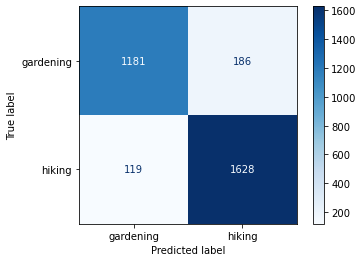

In [30]:
plot_confusion_matrix(gs5, X_test,y_test, display_labels=('gardening','hiking'), cmap='Blues')

In [71]:
# Since this is the best so far using CountVectorizer, I will input this into my model summary

input_to_df(gs5, 'minimal', 'no')

#### Best Countvectorizer model  

- Score on train data:  0.9596316522111575
- Score on test data: 0.9020552344251767
- Parameters:
    - countvectorizer__max_features: 5000
    - countvectorizer__ngram_range: (1, 1)
    - countvectorizer__stop_words: None
    - logisticregression__C: 0.001

In [29]:
pd.DataFrame(gs5.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_countvectorizer__max_features,param_countvectorizer__ngram_range,param_countvectorizer__stop_words,param_logisticregression__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.229512,0.004292,0.036296,0.001047,4000,"(1, 1)",None,0.001,"{'countvectorizer__max_features': 4000, 'count...",0.894540,0.889722,0.887580,0.891863,0.904124,0.893566,0.005761,2
1,0.218464,0.031928,0.033798,0.003194,4000,"(1, 1)",None,0.005,"{'countvectorizer__max_features': 4000, 'count...",0.896681,0.887045,0.892934,0.891328,0.897697,0.893137,0.003841,5
2,0.170040,0.024149,0.029346,0.003140,4000,"(1, 1)",english,0.001,"{'countvectorizer__max_features': 4000, 'count...",0.888651,0.881692,0.891328,0.889186,0.896090,0.889389,0.004658,12
3,0.172586,0.021783,0.030955,0.006263,4000,"(1, 1)",english,0.005,"{'countvectorizer__max_features': 4000, 'count...",0.890257,0.892398,0.892934,0.890792,0.890734,0.891423,0.001046,7
4,0.188525,0.020840,0.030522,0.003319,4500,"(1, 1)",None,0.001,"{'countvectorizer__max_features': 4500, 'count...",0.892398,0.889186,0.885439,0.891328,0.904124,0.892495,0.006282,6
5,0.195320,0.004498,0.037246,0.002814,4500,"(1, 1)",None,0.005,"{'countvectorizer__max_features': 4500, 'count...",0.897216,0.890257,0.891328,0.889186,0.898232,0.893244,0.003734,4
6,0.169137,0.005280,0.029167,0.007317,4500,"(1, 1)",english,0.001,"{'countvectorizer__max_features': 4500, 'count...",0.890257,0.880621,0.888651,0.889722,0.900911,0.890032,0.006465,10
7,0.178086,0.006137,0.032455,0.010847,4500,"(1, 1)",english,0.005,"{'countvectorizer__max_features': 4500, 'count...",0.891328,0.889722,0.889186,0.890257,0.892341,0.890567,0.001135,9
8,0.185128,0.008162,0.033299,0.005075,5000,"(1, 1)",None,0.001,"{'countvectorizer__max_features': 5000, 'count...",0.890257,0.889722,0.890792,0.892934,0.906267,0.893994,0.006232,1
9,0.201129,0.010668,0.032075,0.002612,5000,"(1, 1)",None,0.005,"{'countvectorizer__max_features': 5000, 'count...",0.890257,0.894540,0.891863,0.891328,0.898768,0.893351,0.003054,3


### TfidfVectorizer does slightly better

In [72]:
pipe20 = make_pipeline(TfidfVectorizer(),
                     StandardScaler(with_mean=False),
                    LogisticRegression(max_iter=10000))
params20 = { 
          'tfidfvectorizer__stop_words': [None, 'english'], 
          'tfidfvectorizer__max_features':[4000,5000],
          'tfidfvectorizer__ngram_range':[(1,1),(1,2)],
          'logisticregression__C':[.001, .005]
}

gs20 = GridSearchCV(pipe20, params20, n_jobs = -1)

In [73]:
model_fit_and_scores(gs20)

 accuracy score on train data:  0.9688403469322198
 accuracy score on test data: 0.9020552344251767
 balanced accuracy score on train data: 0.9671635110033101
 balanced accuracy score on test data: 0.8987845816990481
{'logisticregression__C': 0.001, 'tfidfvectorizer__max_features': 5000, 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__stop_words': None}


In [74]:
# Since TfidfVectorizer did slightly better than the best CountVectorizer model, I will input this into my model summary

input_to_df(gs20, 'minimal', 'no')

In [ ]:
#Checking highest and lowest correlated words...

In [35]:
best = gs20.best_estimator_

In [38]:
coefs = best.named_steps['logisticregression'].coef_
vocab = best.named_steps['tfidfvectorizer'].get_feature_names()

In [39]:
coef_df = pd.DataFrame({'coefs': coefs[0], 'word': vocab})

In [40]:
coef_df.nlargest(10,'coefs')

,coefs,word
1933,0.198537,hiking
1926,0.183930,hike
4561,0.140328,trail
3131,0.121242,park
4692,0.100061,usa
2312,0.091811,lake
2788,0.091624,mountain
2840,0.082691,national
2789,0.081796,mountains
1420,0.079084,falls


In [41]:
coef_df.nsmallest(10,'coefs')

,coefs,word
1626,-0.148755,garden
3303,-0.131526,plant
3310,-0.111980,plants
1630,-0.095615,gardening
1763,-0.091510,grow
2818,-0.090062,my
4451,-0.078420,they
1525,-0.075742,flowers
1764,-0.075234,growing
4126,-0.075117,soil
